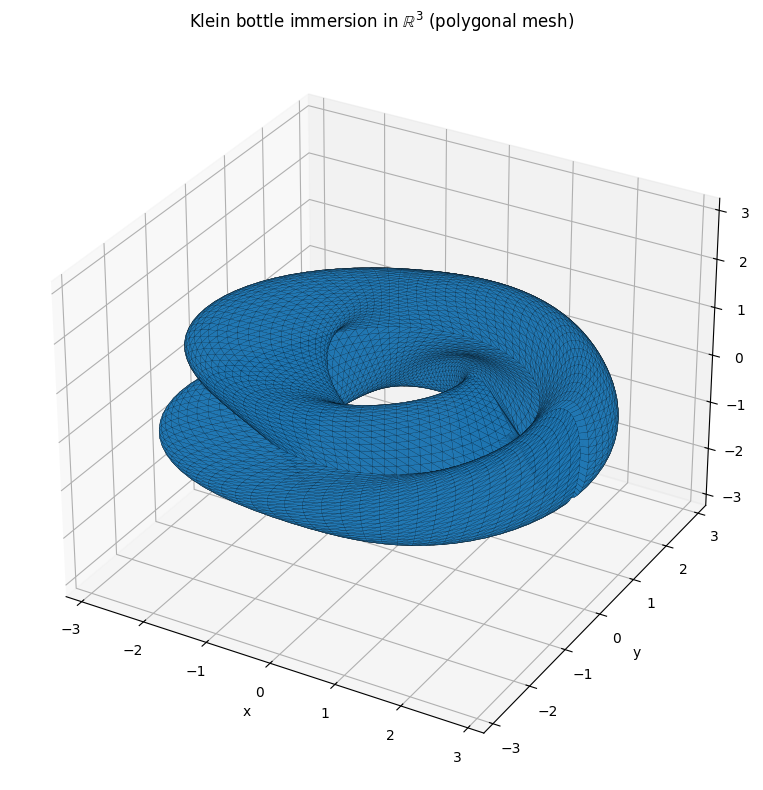

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def klein_immersion(u, v, R=2.0):
    """
    Standard Klein bottle immersion in R^3.
    u, v can be numpy arrays (broadcastable).
    """
    x = (R + np.cos(u/2) * np.sin(v) - np.sin(u/2) * np.sin(2*v)) * np.cos(u)
    y = (R + np.cos(u/2) * np.sin(v) - np.sin(u/2) * np.sin(2*v)) * np.sin(u)
    z =  np.sin(u/2) * np.sin(v) + np.cos(u/2) * np.sin(2*v)
    return x, y, z


# ---- 1. sample parameter domain ----
Nu, Nv = 80, 80   # number of samples in u, v
u = np.linspace(0, 2*np.pi, Nu, endpoint=False)
v = np.linspace(0, 2*np.pi, Nv, endpoint=False)
U, V = np.meshgrid(u, v, indexing="ij")   # U.shape = (Nu, Nv), V.shape = (Nu, Nv)

X, Y, Z = klein_immersion(U, V)

# ---- 2. build polygonal mesh (vertices + faces) ----

# vertices: flatten the grid
vertices = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
# index helper: vertex index at grid position (i,j)
def idx(i, j):
    # wrap around both directions to make closed surface
    return (i % Nu) * Nv + (j % Nv)

faces = []
for i in range(Nu):
    for j in range(Nv):
        # four corners of a "cell" in parameter space (with periodic wrap)
        v00 = idx(i,   j)
        v10 = idx(i+1, j)
        v11 = idx(i+1, j+1)
        v01 = idx(i,   j+1)

        # two triangles per quad: (v00, v10, v11) and (v00, v11, v01)
        faces.append([v00, v10, v11])
        faces.append([v00, v11, v01])

faces = np.array(faces, dtype=int)


# ---- 3. visualize with matplotlib ----

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# build list of triangles for Poly3DCollection
triangles = [vertices[face] for face in faces]
mesh = Poly3DCollection(triangles, alpha=0.9, linewidths=0.1)
mesh.set_edgecolor("k")   # thin black edges (optional)
ax.add_collection3d(mesh)

# set limits
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Klein bottle immersion in $\mathbb{R}^3$ (polygonal mesh)")

plt.tight_layout()
plt.show()


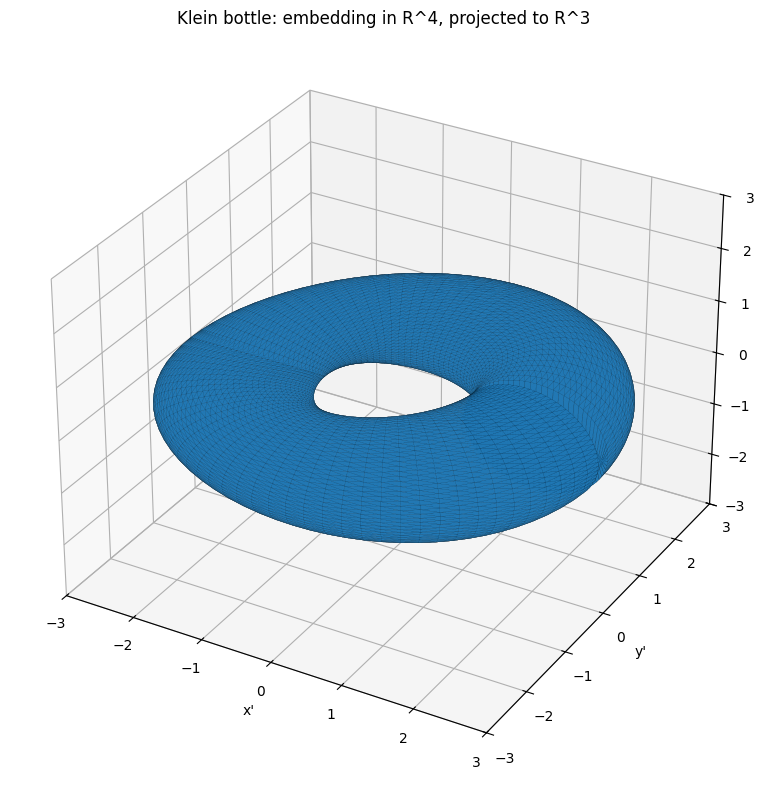

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------- 1. Klein bottle embedding into R^4 ----------

def klein_R4(x, y, r=1.0, a=2.0):
    """
    Klein bottle embedding F: R^2 -> R^4

    F(x,y) = ((r cos y + a) cos x,
              (r cos y + a) sin x,
              r sin y cos(x/2),
              r sin y sin(x/2))
    """
    X1 = (r * np.cos(y) + a) * np.cos(x)
    X2 = (r * np.cos(y) + a) * np.sin(x)
    X3 = r * np.sin(y) * np.cos(x / 2.0)
    X4 = r * np.sin(y) * np.sin(x / 2.0)
    return X1, X2, X3, X4


# ---------- 2. Sample parameter domain (grid in (x,y)) ----------

Nx, Ny = 80, 80
x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
Xparam, Yparam = np.meshgrid(x, y, indexing="ij")

X1, X2, X3, X4 = klein_R4(Xparam, Yparam)


# ---------- 3. Build a triangle mesh in R^4 (vertices + faces) ----------

# vertices in R^4
vertices4 = np.column_stack([
    X1.ravel(),
    X2.ravel(),
    X3.ravel(),
    X4.ravel()
])

def idx(i, j):
    """Index of vertex at grid position (i,j) with periodic wrap."""
    return (i % Nx) * Ny + (j % Ny)

faces = []
for i in range(Nx):
    for j in range(Ny):
        v00 = idx(i,   j)
        v10 = idx(i+1, j)
        v11 = idx(i+1, j+1)
        v01 = idx(i,   j+1)
        faces.append([v00, v10, v11])
        faces.append([v00, v11, v01])

faces = np.array(faces, dtype=int)


# ---------- 4. Project R^4 -> R^3 ----------

# Option A: simple orthogonal projection (drop the 4th coordinate)
# P is a 3x4 matrix; here we just keep (X1, X2, X3)
P = np.array([
    [1, 0, 0, 0],   # x' = X1
    [0, 1, 0, 0],   # y' = X2
    [0, 0, 1, 0]    # z' = X3
])

vertices3 = vertices4 @ P.T   # shape: (Nverts, 3)


# ---------- 5. Visualize projected Klein bottle mesh in R^3 ----------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

triangles = [vertices3[face] for face in faces]
mesh = Poly3DCollection(triangles, alpha=0.9, linewidths=0.05)
mesh.set_edgecolor("k")   # thin edges for structure
ax.add_collection3d(mesh)

# Nice bounding box
xs, ys, zs = vertices3[:,0], vertices3[:,1], vertices3[:,2]
max_range = np.array([xs.max()-xs.min(),
                      ys.max()-ys.min(),
                      zs.max()-zs.min()]).max() / 2.0
mid_x = (xs.max()+xs.min()) * 0.5
mid_y = (ys.max()+ys.min()) * 0.5
mid_z = (zs.max()+zs.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel("x'")
ax.set_ylabel("y'")
ax.set_zlabel("z'")
ax.set_title("Klein bottle: embedding in R^4, projected to R^3")

plt.tight_layout()
plt.show()


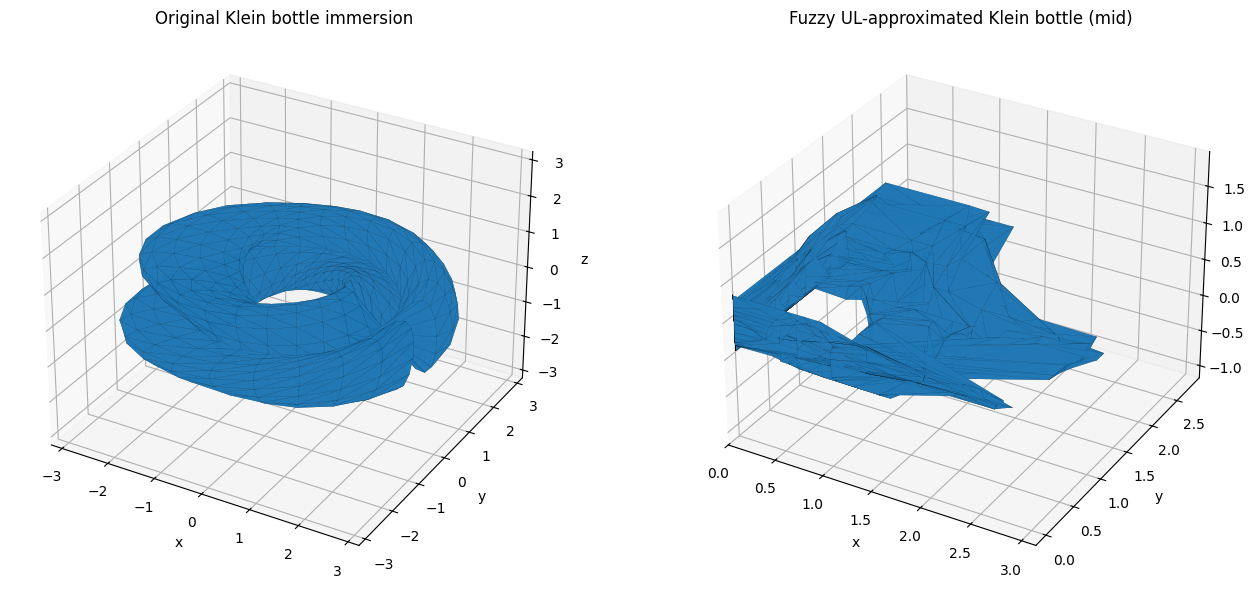

Mean L2 error on grid: 1.4718840010311303
Max  L2 error on grid: 3.309060202567134


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# =========================================================
# 1. Klein bottle immersion in R^3
# =========================================================

def klein_immersion(u, v, R=2.0):
    """
    Standard Klein bottle immersion in R^3.
    u, v can be numpy arrays.
    """
    x = (R + np.cos(u/2) * np.sin(v) - np.sin(u/2) * np.sin(2*v)) * np.cos(u)
    y = (R + np.cos(u/2) * np.sin(v) - np.sin(u/2) * np.sin(2*v)) * np.sin(u)
    z = np.sin(u/2) * np.sin(v) + np.cos(u/2) * np.sin(2*v)
    return x, y, z


# =========================================================
# 2. Fuzzy machinery: triangular membership, partitions,
#    upper & lower functionals, reconstruction
# =========================================================

def triangular_membership(x, a, b, c):
    """
    Triangular fuzzy membership (vectorized).
    """
    x = np.asarray(x)
    mu = np.zeros_like(x, dtype=float)

    left = (a <= x) & (x <= b)
    mu[left] = (x[left] - a) / (b - a)

    right = (b < x) & (x <= c)
    mu[right] = (c - x[right]) / (c - b)

    return mu


def make_partitions(xmin, xmax, n_terms):
    """
    Build n_terms triangular fuzzy sets over [xmin, xmax]
    with equally spaced centers.
    """
    centers = np.linspace(xmin, xmax, n_terms)
    if n_terms > 1:
        k = centers[1] - centers[0]
    else:
        k = xmax - xmin
    return [(c - k, c, c + k) for c in centers]


def compute_F_A_up(U, V, Z, params_u, params_v):
    """
    2D fuzzy upper functional:
        F_A^up = max_{(u,v)} mu_A(u,v) * Z(u,v)
    where mu_A(u,v) = min(mu_u(u), mu_v(v)) for each rectangle A.
    """
    results = []
    for iu, (au, bu, cu) in enumerate(params_u):
        mu_u = triangular_membership(U, au, bu, cu)
        for iv, (av, bv, cv) in enumerate(params_v):
            mu_v = triangular_membership(V, av, bv, cv)
            mu = np.minimum(mu_u, mu_v)
            if np.any(mu > 0):
                F_up = np.max(mu * Z)
            else:
                F_up = 0.0
            results.append({
                "params_u": (au, bu, cu),
                "params_v": (av, bv, cv),
                "F_up": F_up
            })
    return results


def compute_F_A_down(U, V, Z, params_u, params_v):
    """
    2D fuzzy lower functional:
        F_A^down = min_{(u,v), mu_A>0} Z(u,v) / mu_A(u,v)
        (infinity where mu_A = 0).
    """
    results = []
    for iu, (au, bu, cu) in enumerate(params_u):
        mu_u = triangular_membership(U, au, bu, cu)
        for iv, (av, bv, cv) in enumerate(params_v):
            mu_v = triangular_membership(V, av, bv, cv)
            mu = np.minimum(mu_u, mu_v)

            ratios = np.full_like(Z, np.inf, dtype=float)
            mask = mu > 0
            ratios[mask] = Z[mask] / mu[mask]
            F_down = np.min(ratios)

            results.append({
                "params_u": (au, bu, cu),
                "params_v": (av, bv, cv),
                "F_down": F_down
            })
    return results


def f_up_point(u, v, results_up):
    """
    Reconstruct f^up(u,v) = min_A F_A^up / mu_A(u,v).
    """
    ratios = []
    for r in results_up:
        au, bu, cu = r["params_u"]
        av, bv, cv = r["params_v"]
        F = r["F_up"]

        mu_u = triangular_membership(np.array([u]), au, bu, cu)[0]
        mu_v = triangular_membership(np.array([v]), av, bv, cv)[0]
        mu = min(mu_u, mu_v)

        if mu > 0:
            ratios.append(F / mu)
    return min(ratios) if ratios else 0.0


def f_down_point(u, v, results_down):
    """
    Reconstruct f^down(u,v) = max_A mu_A(u,v) * F_A^down.
    """
    values = []
    for r in results_down:
        au, bu, cu = r["params_u"]
        av, bv, cv = r["params_v"]
        F = r["F_down"]

        mu_u = triangular_membership(np.array([u]), au, bu, cu)[0]
        mu_v = triangular_membership(np.array([v]), av, bv, cv)[0]
        mu = min(mu_u, mu_v)

        values.append(mu * F)
    return max(values) if values else 0.0


# =========================================================
# 3. MAIN: approximate Klein bottle immersion (x,y,z)
#    by upper & lower fuzzy transforms
# =========================================================

# parameter grid on [0, 2π]^2
Nu, Nv = 25, 25
u_vec = np.linspace(0, 2*np.pi, Nu, endpoint=False)
v_vec = np.linspace(0, 2*np.pi, Nv, endpoint=False)
U, V = np.meshgrid(u_vec, v_vec, indexing="ij")  # shape (Nu, Nv)

# original Klein bottle immersion
X_true, Y_true, Z_true = klein_immersion(U, V)

# fuzzy partitions in parameter space (u, v)
params_u = make_partitions(0, 2*np.pi, n_terms=5)
params_v = make_partitions(0, 2*np.pi, n_terms=5)

# --- compute F_A^up / F_A^down FOR EACH COORDINATE SEPARATELY ---
results_up_x   = compute_F_A_up(U, V, X_true, params_u, params_v)
results_down_x = compute_F_A_down(U, V, X_true, params_u, params_v)

results_up_y   = compute_F_A_up(U, V, Y_true, params_u, params_v)
results_down_y = compute_F_A_down(U, V, Y_true, params_u, params_v)

results_up_z   = compute_F_A_up(U, V, Z_true, params_u, params_v)
results_down_z = compute_F_A_down(U, V, Z_true, params_u, params_v)

# --- reconstruct approximations on the grid ---
X_up   = np.zeros_like(X_true)
X_down = np.zeros_like(X_true)
Y_up   = np.zeros_like(Y_true)
Y_down = np.zeros_like(Y_true)
Z_up   = np.zeros_like(Z_true)
Z_down = np.zeros_like(Z_true)

for i, u in enumerate(u_vec):
    for j, v in enumerate(v_vec):
        X_up[i, j]   = f_up_point(u, v, results_up_x)
        X_down[i, j] = f_down_point(u, v, results_down_x)

        Y_up[i, j]   = f_up_point(u, v, results_up_y)
        Y_down[i, j] = f_down_point(u, v, results_down_y)

        Z_up[i, j]   = f_up_point(u, v, results_up_z)
        Z_down[i, j] = f_down_point(u, v, results_down_z)

# mid-surface as a single approximation of the Klein bottle
X_mid = 0.5 * (X_up + X_down)
Y_mid = 0.5 * (Y_up + Y_down)
Z_mid = 0.5 * (Z_up + Z_down)


# =========================================================
# 4. Build mesh & visualize: original vs fuzzy-approximated
# =========================================================

# vertices for original and approximated surfaces
verts_true = np.column_stack((X_true.ravel(), Y_true.ravel(), Z_true.ravel()))
verts_mid  = np.column_stack((X_mid.ravel(),  Y_mid.ravel(),  Z_mid.ravel()))

def idx(i, j):
    return (i % Nu) * Nv + (j % Nv)

faces = []
for i in range(Nu):
    for j in range(Nv):
        v00 = idx(i,   j)
        v10 = idx(i+1, j)
        v11 = idx(i+1, j+1)
        v01 = idx(i,   j+1)
        faces.append([v00, v10, v11])
        faces.append([v00, v11, v01])
faces = np.array(faces, dtype=int)


def plot_mesh(vertices, faces, title, ax):
    tris = [vertices[f] for f in faces]
    mesh = Poly3DCollection(tris, alpha=0.9, linewidths=0.05)
    mesh.set_edgecolor("k")
    ax.add_collection3d(mesh)

    xs, ys, zs = vertices[:,0], vertices[:,1], vertices[:,2]
    max_range = np.array([xs.max()-xs.min(),
                          ys.max()-ys.min(),
                          zs.max()-zs.min()]).max() / 2.0
    mid_x = (xs.max()+xs.min()) * 0.5
    mid_y = (ys.max()+ys.min()) * 0.5
    mid_z = (zs.max()+zs.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(title)


fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
plot_mesh(verts_true, faces, "Original Klein bottle immersion", ax1)

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_mesh(verts_mid, faces, "Fuzzy UL-approximated Klein bottle (mid)", ax2)

plt.tight_layout()
plt.show()

# Optionally: measure approximation error in R^3
err = np.sqrt((X_true - X_mid)**2 + (Y_true - Y_mid)**2 + (Z_true - Z_mid)**2)
print("Mean L2 error on grid:", np.mean(err))
print("Max  L2 error on grid:", np.max(err))


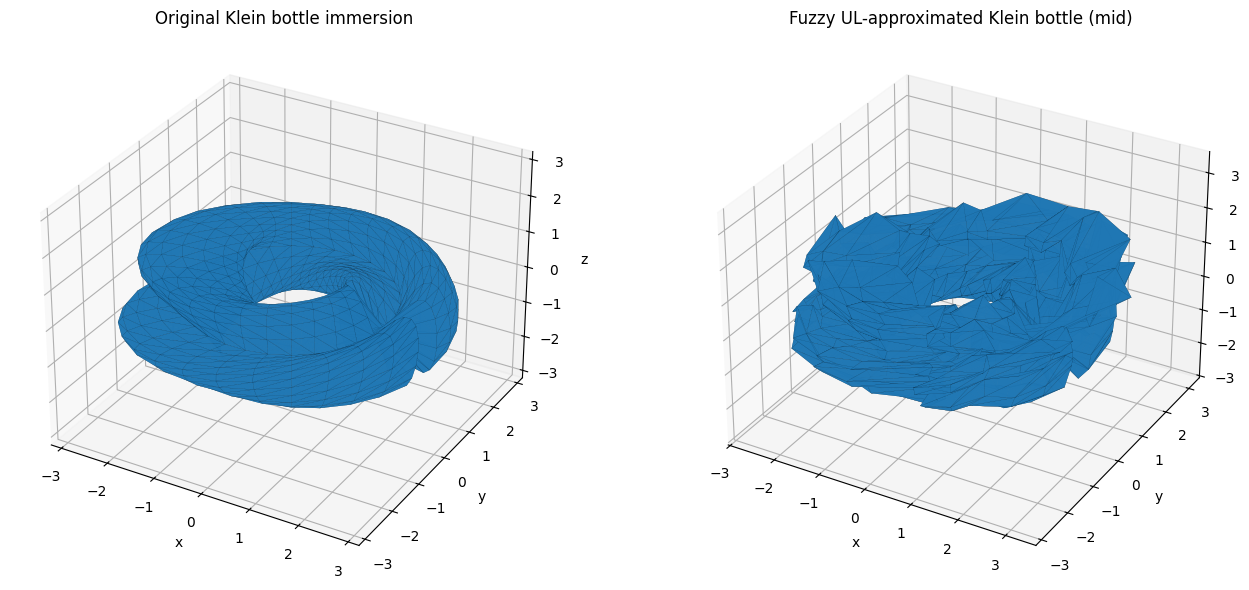

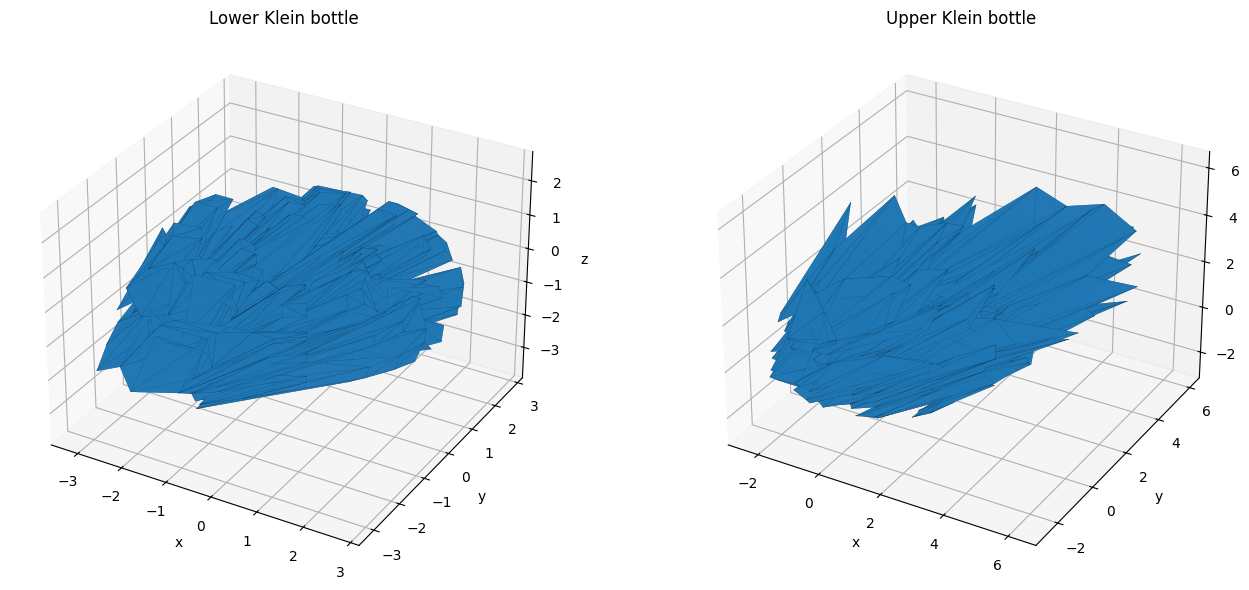

Mean L2 error on grid: 0.2967751794788776
Max  L2 error on grid: 1.237909840682857


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

partition=25
discretization=30
# =========================================================
# 1. Klein bottle immersion in R^3
# =========================================================

def klein_immersion(u, v, R=2.0):
    """
    Standard Klein bottle immersion in R^3.
    u, v can be numpy arrays.
    """
    x = (R + np.cos(u / 2) * np.sin(v) - np.sin(u / 2) * np.sin(2 * v)) * np.cos(u)
    y = (R + np.cos(u / 2) * np.sin(v) - np.sin(u / 2) * np.sin(2 * v)) * np.sin(u)
    z = np.sin(u / 2) * np.sin(v) + np.cos(u / 2) * np.sin(2 * v)
    return x, y, z


# =========================================================
# 2. Fuzzy machinery
#    - triangular membership
#    - partitions
#    - F_A^up, F_A^down
#    - reconstruction f^up, f^down
# =========================================================

def triangular_membership(x, a, b, c):
    """
    Triangular fuzzy membership (vectorized).
    """
    x = np.asarray(x)
    mu = np.zeros_like(x, dtype=float)

    if b != a:
        left = (a <= x) & (x <= b)
        mu[left] = (x[left] - a) / (b - a)
    if c != b:
        right = (b < x) & (x <= c)
        mu[right] = (c - x[right]) / (c - b)

    return mu


def make_partitions(xmin, xmax, n_terms):
    """
    Build n_terms triangular fuzzy sets over [xmin, xmax]
    with equally spaced centers.
    """
    centers = np.linspace(xmin, xmax, n_terms)
    if n_terms > 1:
        k = centers[1] - centers[0]
    else:
        k = xmax - xmin if xmax > xmin else 1.0
    return [(c - k, c, c + k) for c in centers]


def compute_F_A_up(U, V, Z, params_u, params_v):
    """
    2D fuzzy upper functional:
        F_A^up = max_{(u,v)} mu_A(u,v) * Z(u,v)
    where mu_A(u,v) = min(mu_u(u), mu_v(v)) for each rectangle A.
    """
    results = []
    for iu, (au, bu, cu) in enumerate(params_u):
        mu_u = triangular_membership(U, au, bu, cu)
        for iv, (av, bv, cv) in enumerate(params_v):
            mu_v = triangular_membership(V, av, bv, cv)
            mu = np.minimum(mu_u, mu_v)
            if np.any(mu > 0):
                F_up = np.max(mu * Z)
            else:
                F_up = 0.0
            results.append({
                "params_u": (au, bu, cu),
                "params_v": (av, bv, cv),
                "F_up": F_up
            })
    return results


def compute_F_A_down(U, V, Z, params_u, params_v):
    """
    2D fuzzy lower functional:
        F_A^down = min_{(u,v), mu_A>0} Z(u,v) / mu_A(u,v)
        (infinity where mu_A = 0).
    """
    results = []
    for iu, (au, bu, cu) in enumerate(params_u):
        mu_u = triangular_membership(U, au, bu, cu)
        for iv, (av, bv, cv) in enumerate(params_v):
            mu_v = triangular_membership(V, av, bv, cv)
            mu = np.minimum(mu_u, mu_v)

            ratios = np.full_like(Z, np.inf, dtype=float)
            mask = mu > 0
            ratios[mask] = Z[mask] / mu[mask]
            F_down = np.min(ratios)

            results.append({
                "params_u": (au, bu, cu),
                "params_v": (av, bv, cv),
                "F_down": F_down
            })
    return results


def f_up_point(u, v, results_up):
    """
    Reconstruct f^up(u,v) = min_A F_A^up / mu_A(u,v).
    """
    ratios = []
    for r in results_up:
        au, bu, cu = r["params_u"]
        av, bv, cv = r["params_v"]
        F = r["F_up"]

        mu_u = triangular_membership(np.array([u]), au, bu, cu)[0]
        mu_v = triangular_membership(np.array([v]), av, bv, cv)[0]
        mu = min(mu_u, mu_v)

        if mu > 0:
            ratios.append(F / mu)
    return min(ratios) if ratios else 0.0


def f_down_point(u, v, results_down):
    """
    Reconstruct f^down(u,v) = max_A mu_A(u,v) * F_A^down.
    """
    values = []
    for r in results_down:
        au, bu, cu = r["params_u"]
        av, bv, cv = r["params_v"]
        F = r["F_down"]

        mu_u = triangular_membership(np.array([u]), au, bu, cu)[0]
        mu_v = triangular_membership(np.array([v]), av, bv, cv)[0]
        mu = min(mu_u, mu_v)

        values.append(mu * F)
    return max(values) if values else 0.0


# =========================================================
# 3. MAIN: approximate Klein bottle immersion (x,y,z)
#    with shifted coordinates (>1), then shift back
# =========================================================

def main():
    # parameter grid on [0, 2π]^2
    Nu, Nv = discretization, discretization  # grid resolution in parameter space
    u_vec = np.linspace(0, 2 * np.pi, Nu, endpoint=False)
    v_vec = np.linspace(0, 2 * np.pi, Nv, endpoint=False)
    U, V = np.meshgrid(u_vec, v_vec, indexing="ij")  # shape (Nu, Nv)

    # original Klein bottle immersion
    X_true, Y_true, Z_true = klein_immersion(U, V)

    # ------------------------------------------------------
    # SHIFT ALL COORDINATE FUNCTIONS ABOVE 1
    # ------------------------------------------------------
    all_vals = np.concatenate([X_true.ravel(), Y_true.ravel(), Z_true.ravel()])
    shift = 1.0 - np.min(all_vals) + 1e-6  # ensure strictly > 1

    X_shift = X_true + shift
    Y_shift = Y_true + shift
    Z_shift = Z_true + shift

    # fuzzy partitions in parameter space (u, v)
    params_u = make_partitions(0, 2 * np.pi, n_terms=partition)
    params_v = make_partitions(0, 2 * np.pi, n_terms=partition)

    # --- compute F_A^up / F_A^down FOR EACH COORDINATE (on shifted data) ---
    results_up_x   = compute_F_A_up(U, V, X_shift, params_u, params_v)
    results_down_x = compute_F_A_down(U, V, X_shift, params_u, params_v)

    results_up_y   = compute_F_A_up(U, V, Y_shift, params_u, params_v)
    results_down_y = compute_F_A_down(U, V, Y_shift, params_u, params_v)

    results_up_z   = compute_F_A_up(U, V, Z_shift, params_u, params_v)
    results_down_z = compute_F_A_down(U, V, Z_shift, params_u, params_v)

    # --- reconstruct approximations on the grid (still shifted) ---
    X_up   = np.zeros_like(X_true)
    X_down = np.zeros_like(X_true)
    Y_up   = np.zeros_like(Y_true)
    Y_down = np.zeros_like(Y_true)
    Z_up   = np.zeros_like(Z_true)
    Z_down = np.zeros_like(Z_true)

    for i, u in enumerate(u_vec):
        for j, v in enumerate(v_vec):
            X_up[i, j]   = f_up_point(u, v, results_up_x)
            X_down[i, j] = f_down_point(u, v, results_down_x)

            Y_up[i, j]   = f_up_point(u, v, results_up_y)
            Y_down[i, j] = f_down_point(u, v, results_down_y)

            Z_up[i, j]   = f_up_point(u, v, results_up_z)
            Z_down[i, j] = f_down_point(u, v, results_down_z)

    # mid-surface in shifted coordinates
    X_mid_shift = 0.5 * (X_up + X_down)
    Y_mid_shift = 0.5 * (Y_up + Y_down)
    Z_mid_shift = 0.5 * (Z_up + Z_down)

    # ------------------------------------------------------
    # SHIFT BACK to original scale for visualization
    # ------------------------------------------------------
    X_up   -= shift
    X_down -= shift
    Y_up   -= shift
    Y_down -= shift
    Z_up   -= shift
    Z_down -= shift

    X_mid = X_mid_shift - shift
    Y_mid = Y_mid_shift - shift
    Z_mid = Z_mid_shift - shift

    # =====================================================
    # 4. Build triangle mesh & visualize
    # =====================================================

    # flatten to vertex arrays
    verts_true = np.column_stack((X_true.ravel(), Y_true.ravel(), Z_true.ravel()))
    verts_mid  = np.column_stack((X_mid.ravel(),  Y_mid.ravel(),  Z_mid.ravel()))
    verts_down  = np.column_stack((X_down.ravel(),  Y_down.ravel(),  Z_down.ravel()))
    verts_up  = np.column_stack((X_up.ravel(),  Y_up.ravel(),  Z_up.ravel()))

    def idx(i, j):
        return (i % Nu) * Nv + (j % Nv)

    faces = []
    for i in range(Nu):
        for j in range(Nv):
            v00 = idx(i,   j)
            v10 = idx(i+1, j)
            v11 = idx(i+1, j+1)
            v01 = idx(i,   j+1)
            faces.append([v00, v10, v11])
            faces.append([v00, v11, v01])
    faces = np.array(faces, dtype=int)

    def plot_mesh(vertices, faces, title, ax):
        tris = [vertices[f] for f in faces]
        mesh = Poly3DCollection(tris, alpha=0.9, linewidths=0.05)
        mesh.set_edgecolor("k")
        ax.add_collection3d(mesh)

        xs, ys, zs = vertices[:, 0], vertices[:, 1], vertices[:, 2]
        max_range = np.array([
            xs.max() - xs.min(),
            ys.max() - ys.min(),
            zs.max() - zs.min()
        ]).max() / 2.0
        mid_x = (xs.max() + xs.min()) * 0.5
        mid_y = (ys.max() + ys.min()) * 0.5
        mid_z = (zs.max() + zs.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(title)

    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    plot_mesh(verts_true, faces, "Original Klein bottle immersion", ax1)

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    plot_mesh(verts_mid, faces, "Fuzzy UL-approximated Klein bottle (mid)", ax2)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    plot_mesh(verts_down, faces, "Lower Klein bottle", ax1)

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    plot_mesh(verts_up, faces, "Upper Klein bottle", ax2)

    plt.tight_layout()
    plt.show()
    # =====================================================
    # 5. Error diagnostics (in R^3)
    # =====================================================
    err = np.sqrt(
        (X_true - X_mid) ** 2 +
        (Y_true - Y_mid) ** 2 +
        (Z_true - Z_mid) ** 2
    )
    print("Mean L2 error on grid:", np.mean(err))
    print("Max  L2 error on grid:", np.max(err))


if __name__ == "__main__":
    main()
